In [2]:
import markhov
import em
import numpy as np
import pandas as pd
from florisplotlib import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Demonstrating EM

Here we demonstrate the use and behaviour of the various functions in our expectation maximisation algorithm for learning rule probagbilities for a two-part grammar made up of a finite state automaton that generates strings of operations and a bigram grammar of legal transitions for the operation Merge.

### Get set up

Some functions for log-transforming the grammar

Make some transitions

In [3]:
trans = {'a':['a','b'],
           'b':['b','a'],
           '[':['a','b']
       }


In [4]:
trans_probs = {'a':{'a':0.5,'b':0.5},
           'b':{'b':0.5,'a':0.5},
           '[':{'a':0.5,'b':0.5}
       }

trans_probs=markhov.fsa_log(trans_probs)

Operations FSA

In [5]:
ops = {'S':[('NotCL','mg')], # from start we have to merge
       'NotCL':[('NotCL','mg'),('NotCL','copy'), # this state is the state in which the last "special" operation was *not* Clear. Either we've done none or the last was copy. From here we can do everything including end
               ('CLEAR_S','clear'), # go here to clear the buffer
               ('F','end') # go here to end
           ],
       'CLEAR_S':[('CLEAR','mg')], # this is where we've just cleared. Buffer is empty so you can only Merge
       'CLEAR':[('CLEAR','mg'), # the last special op was Clear so we can Copy or Merge.
                ('NotCL','copy') # if we Copy, the last special op was Copy so go to NotCL
            ],
       'F':[] #final state
   }


In [6]:
ops_probs=em.initialise(ops)

A corpus

In [7]:
aaa = ['a','a a','a a a']

### Parse a sentence

In [8]:
s=aaa[-1]

In [9]:
parses=markhov.parse(s,trans,ops)

In [10]:
for i in range(len(parses)):
    print(markhov.parse2string(parses[i]))


bigrams: [ a a a
buffer: a a a
op states: S NotCL NotCL NotCL F
operations: mg mg mg end
k: 3

bigrams: [ a a
buffer: a a a
op states: S NotCL NotCL NotCL F
operations: mg copy mg end
k: 3

bigrams: [ a a
buffer: a a
op states: S NotCL CLEAR_S CLEAR NotCL F
operations: mg clear mg copy end
k: 3


### Parse the corpus

In [11]:
parsed_corpus=em.parse_corpus(aaa,trans,ops)

In [19]:
print(em.parsed_corpus2string(parsed_corpus))


Parse 0:
Sentence: 0
bigrams: [ a
Q: S NotCL F
E: mg end
SC:
  S 1
  F 1
  NotCL 1
TC:
  S mg NotCL 1
  NotCL end F 1
UC:
  [ 1
BC:
  [ a 1

Parse 1:
Sentence: 1
bigrams: [ a a
Q: S NotCL NotCL F
E: mg mg end
SC:
  S 1
  F 1
  NotCL 2
TC:
  NotCL mg NotCL 1
  S mg NotCL 1
  NotCL end F 1
UC:
  a 1
  [ 1
BC:
  [ a 1
  a a 1

Parse 2:
Sentence: 1
bigrams: [ a
Q: S NotCL NotCL F
E: mg copy end
SC:
  S 1
  F 1
  NotCL 2
TC:
  S mg NotCL 1
  NotCL end F 1
  NotCL copy NotCL 1
UC:
  [ 1
BC:
  [ a 1

Parse 3:
Sentence: 2
bigrams: [ a a a
Q: S NotCL NotCL NotCL F
E: mg mg mg end
SC:
  S 1
  F 1
  NotCL 3
TC:
  NotCL mg NotCL 2
  S mg NotCL 1
  NotCL end F 1
UC:
  a 2
  [ 1
BC:
  [ a 1
  a a 2

Parse 4:
Sentence: 2
bigrams: [ a a
Q: S NotCL NotCL NotCL F
E: mg copy mg end
SC:
  S 1
  F 1
  NotCL 3
TC:
  NotCL mg NotCL 1
  S mg NotCL 1
  NotCL end F 1
  NotCL copy NotCL 1
UC:
  a 1
  [ 1
BC:
  [ a 1
  a a 1

Parse 5:
Sentence: 2
bigrams: [ a a
Q: S NotCL CLEAR_S CLEAR NotCL F
E: mg clear mg cop

Make a parallel list of parse relative probabilities

In [20]:
parse_probs=em.get_p_parses(parsed_corpus,ops_probs,trans_probs)

In [21]:
print(parse_probs)

[1.0, 0.50980930812735048, 0.49019069187264924, 0.038811887630210332, 0.037318318334006992, 0.92386979403578262]


In [23]:
exp_bigrams = em.expected_transition_counts(parsed_corpus,parse_probs,trans,'bc')
exp_unigrams = em.expected_state_counts(parsed_corpus,parse_probs,trans,'uc')

In [24]:
for u in exp_unigrams:
    print ('\nExpected count of %s in each sentence:'%u)
    for s in exp_unigrams[u]:
        print (' %s: %.4f'%(s,exp_unigrams[u][s]))


Expected count of a in each sentence:
 0: 0.0000
 1: 0.5098
 2: 1.0388

Expected count of [ in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000

Expected count of b in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000


In [25]:
for a in exp_bigrams:
    for b in exp_bigrams[a]:
        print ('\nExpected count of %s %s in each sentence:'%(a,b))
        for s in exp_bigrams[a][b]:
            print (' %s: %.4f'%(s,exp_bigrams[a][b][s]))


Expected count of a a in each sentence:
 0: 0.0000
 1: 0.5098
 2: 1.0388

Expected count of a b in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000

Expected count of [ a in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000

Expected count of [ b in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000

Expected count of b a in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000

Expected count of b b in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000


In [27]:
exp_tr = em.expected_transition_counts(parsed_corpus,parse_probs,ops,'tc')
exp_states = em.expected_state_counts(parsed_corpus,parse_probs,ops,'sc')

In [28]:
for u in exp_states:
    print ('\nExpected count of %s in each sentence:'%u)
    for s in exp_states[u]:
        print (' %s: %.4f'%(s,exp_states[u][s]))


Expected count of S in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000

Expected count of NotCL in each sentence:
 0: 1.0000
 1: 2.0000
 2: 2.0761

Expected count of CLEAR_S in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.9239

Expected count of CLEAR in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.9239

Expected count of F in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000


In [33]:
for a in exp_tr:
    for (b,e) in exp_tr[a]:
        print ('\nExpected count of (%s %s %s) in each sentence:'%(a,e,b))
        for s in exp_tr[a][(b,e)]:
            print (' %s: %.4f'%(s,exp_tr[a][(b,e)][s]))


Expected count of (S mg NotCL) in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000

Expected count of (NotCL end F) in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000

Expected count of (NotCL copy NotCL) in each sentence:
 0: 0.0000
 1: 0.4902
 2: 0.0373

Expected count of (NotCL mg NotCL) in each sentence:
 0: 0.0000
 1: 0.5098
 2: 0.1149

Expected count of (NotCL clear CLEAR_S) in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.9239

Expected count of (CLEAR_S mg CLEAR) in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.9239

Expected count of (CLEAR copy NotCL) in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.9239

Expected count of (CLEAR mg CLEAR) in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000


In [35]:
new_ops = em.update(exp_states,exp_tr,ops)

In [37]:
print (markhov.fsa2string(new_ops,False)) # False prints the non-log probs



S
   NotCL mg	1.00

NotCL
   F end	0.59
   NotCL copy	0.10
   NotCL mg	0.12
   CLEAR_S clear	0.18

CLEAR_S
   CLEAR mg	1.00

CLEAR
   NotCL copy	1.00
   CLEAR mg	0.00

F


In [38]:
em.check_fsa(new_ops) # is this a valid probability distribution?

True

In [40]:
new_trans = em.update(exp_unigrams,exp_bigrams,trans)

In [42]:
print (markhov.fsa2string(new_trans))



a
   a	0.00
   b	-inf

[
   a	0.00
   b	-inf

b
   a	-0.69
   b	-0.69


In [44]:
em.check_fsa(new_trans) # check this is a valid probability distribution

True

## Expectation Maximisation time!

In [45]:
n = 30 # number of EM iterations to do

In [46]:
history=em.em(aaa,trans,ops,n) # run EM

In [47]:
#for i,step in enumerate(history):
#    print ('\n--------\n--------\nIteration %i'%i)
#    print ('FSA:')
#    print (markhov.fsa2string(step['fsa']))
#    print ('\n------\nTrans probs:')
#    print (markhov.trans2string(step['trans_probs']))

Display the results

Make the rules into a simpler list

In [49]:
rules=[]
for lhs in ops:
    for (rhs,e) in ops[lhs]:
        rules.append(('%s->%s %s'%(lhs,e,rhs),(lhs,rhs,e)))

Put them and their updating probabilities into a table

In [51]:
tab=[]
for (rule,(lhs,rhs,e)) in rules:
    thisrule={' rule':rule}
    for i in range(n):
        p=history[i]['fsa'][lhs][(rhs,e)]
        thisrule["p.iteration%03d"%i]=p
    tab.append(thisrule)

Use pandas to make the table into a datafram

In [52]:
df = pd.DataFrame(tab)

In [53]:
df

,rule,p.iteration000,p.iteration001,p.iteration002,p.iteration003,p.iteration004,p.iteration005,p.iteration006,p.iteration007,p.iteration008,...,p.iteration020,p.iteration021,p.iteration022,p.iteration023,p.iteration024,p.iteration025,p.iteration026,p.iteration027,p.iteration028,p.iteration029
0,S->mg NotCL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,CLEAR->mg CLEAR,-0.691818,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,CLEAR->copy NotCL,-0.694478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,CLEAR_S->mg CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,NotCL->mg NotCL,-2.450031,-2.823638,-2.718502,-2.578109,-2.427193,-2.276947,-2.130488,-1.988935,-1.852900,...,-0.793251,-0.764167,-0.742694,-0.727264,-0.716411,-0.708900,-0.703761,-0.700274,-0.697921,-0.696340
5,NotCL->copy NotCL,-1.123201,-1.582851,-1.794268,-1.883261,-1.948061,-2.014523,-2.089703,-2.176477,-2.276765,...,-5.007832,-5.368153,-5.740901,-6.123177,-6.512491,-6.906854,-7.304759,-7.705110,-8.107133,-8.510288
6,NotCL->clear CLEAR_S,-1.298973,-1.852692,-1.723064,-1.707458,-1.717894,-1.737199,-1.762213,-1.792886,-1.830074,...,-3.601047,-3.924914,-4.270719,-4.633636,-5.009340,-5.394286,-5.785751,-6.181735,-6.580811,-6.981986
7,NotCL->end F,-1.153090,-0.547477,-0.528889,-0.526509,-0.528104,-0.531018,-0.534722,-0.539157,-0.544381,...,-0.666218,-0.673596,-0.679272,-0.683475,-0.686494,-0.688615,-0.690081,-0.691082,-0.691761,-0.692219


In [54]:
df.to_csv('ops_%s.csv'%('oct_22_2016_aaa')) # print to file

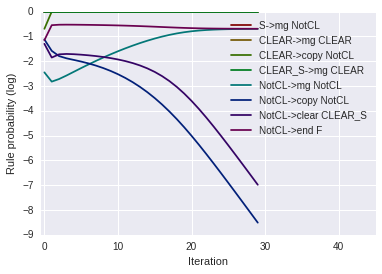

In [55]:
ncol,_ = df.shape
colors = get_colors(ncol)
for i,row in df.iterrows():
    col = colors[i]
    plot(range(n),[ row["p.iteration%03d"%i] for i in range(n) ],'-',color=col,label=row[" rule"])
legend()
xlim(-.5,n+15)
xlabel("Iteration")
ylabel("Rule probability (log)")

Same for the transitions

In [56]:
bigrams=[]
for lhs in trans:
    for rhs in trans[lhs]:
        bigrams.append(('%s,%s'%(lhs,rhs),(lhs,rhs)))

In [57]:
bigrams

[('a,a', ('a', 'a')),
 ('a,b', ('a', 'b')),
 ('[,a', ('[', 'a')),
 ('[,b', ('[', 'b')),
 ('b,b', ('b', 'b')),
 ('b,a', ('b', 'a'))]

In [58]:
tab=[]
for (bi,(lhs,rhs)) in bigrams:
    thisrule={' rule':bi}
    for i in range(n):
        p=history[i]['trans_probs'][lhs][rhs]
        thisrule["p.iteration%i"%i]=p
    tab.append(thisrule)

In [59]:
df_bis = pd.DataFrame(tab)

In [60]:
df_bis

,rule,p.iteration0,p.iteration1,p.iteration10,p.iteration11,p.iteration12,p.iteration13,p.iteration14,p.iteration15,p.iteration16,...,p.iteration27,p.iteration28,p.iteration29,p.iteration3,p.iteration4,p.iteration5,p.iteration6,p.iteration7,p.iteration8,p.iteration9
0,"a,a",-0.845272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"a,b",-0.561138,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,"[,a",-1.475227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"[,b",-0.259713,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,"b,b",-0.726899,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,...,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147
5,"b,a",-0.660497,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,...,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147


In [61]:
df_bis.to_csv('trans_%s.csv'%('oct_22_2016_aaa'))

### Calculate the log likelihood of the corpus given the trained grammar

This is the ll of the corpus at the end of training:

In [62]:
em.ll_corpus(parsed_corpus,history[-1]['trans_probs'],history[-1]['fsa'])

-4.1603930004243486

Make a dataframe of the LL of the corpus throughout training:

In [63]:
tab=[]
for i in range(n):
    this_iter={'iteration':i,
               'likelihood':em.ll_corpus(parsed_corpus,history[i]['trans_probs'],history[i]['fsa'])}
    tab.append(this_iter)

In [64]:
df_lls=pd.DataFrame(tab)

In [65]:
df_lls

,iteration,likelihood
0,0,-11.532369
1,1,-4.728423
2,2,-4.687455
3,3,-4.674171
4,4,-4.660692
5,5,-4.645377
6,6,-4.628002
7,7,-4.608447
8,8,-4.586636
9,9,-4.562543


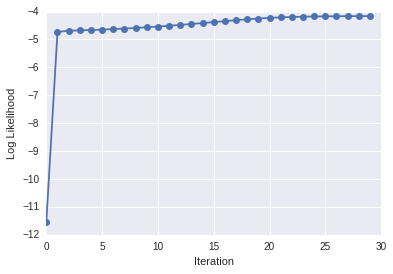

In [66]:
plot(df_lls["iteration"],df_lls["likelihood"],'o-')
xlabel("Iteration")
ylabel("Log Likelihood")

Look at the changing relative probabilities of the parses

In [67]:
tab=[]

for i,(s,parse) in enumerate(parsed_corpus):
    this_parse={' sentence':("%i: %s"%(s,' '.join(parse['s']))),'bigrams':' '.join(parse['bis']),'Q':' '.join(parse['rt'][0]),'E':' '.join(parse['rt'][1])}
    for iter in range(1,n):
        this_parse['iteration_%i p'%iter]=history[iter]['parse_ps'][i]
    tab.append(this_parse)

In [68]:
df.parses=pd.DataFrame(tab)


In [69]:
df.parses


,sentence,E,Q,bigrams,iteration_1 p,iteration_10 p,iteration_11 p,iteration_12 p,iteration_13 p,iteration_14 p,...,iteration_27 p,iteration_28 p,iteration_29 p,iteration_3 p,iteration_4 p,iteration_5 p,iteration_6 p,iteration_7 p,iteration_8 p,iteration_9 p
0,0: a,mg end,S NotCL F,[ a,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1: a a,mg mg end,S NotCL NotCL F,[ a a,0.102284,0.661376,0.716162,0.767335,0.813675,0.854298,...,0.998643,0.999093,0.999395,0.284096,0.332956,0.382457,0.434768,0.489805,0.546749,0.604408
2,1: a a,mg copy end,S NotCL NotCL F,[ a,0.897716,0.338624,0.283838,0.232665,0.186325,0.145702,...,0.001357,0.000907,0.000605,0.715904,0.667044,0.617543,0.565232,0.510195,0.453251,0.395592
3,2: a a a,mg mg mg end,S NotCL NotCL NotCL F,[ a a a,0.019092,0.158191,0.201927,0.254013,0.314572,0.383085,...,0.986284,0.990792,0.993833,0.022454,0.029015,0.039005,0.052572,0.070378,0.093288,0.122248
4,2: a a a,mg copy mg end,S NotCL NotCL NotCL F,[ a a,0.167565,0.080994,0.080030,0.077020,0.072035,0.065336,...,0.001340,0.000899,0.000602,0.056583,0.058129,0.062981,0.068348,0.073307,0.077335,0.080013
5,2: a a a,mg clear mg copy end,S NotCL CLEAR_S CLEAR NotCL F,[ a a,0.813343,0.760816,0.718043,0.668967,0.613393,0.551579,...,0.012375,0.008309,0.005566,0.920962,0.912856,0.898014,0.879081,0.856315,0.829377,0.797739


In [18]:
reload(em)

<module 'em' from 'em.py'>